In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, CSVLogger 
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

from keras.regularizers import l2

%matplotlib inline
import matplotlib.pyplot as plt

# !pip install livelossplot 
from livelossplot import PlotLossesKeras


from keras import backend

from keras.layers import AveragePooling1D, Input, GlobalMaxPooling1D
from keras import layers, models
from keras import backend
import time

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


# import tensorflow as tf

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

Using TensorFlow backend.


# Data

## Load Data set 

(2160, 100, 3) (2160,)


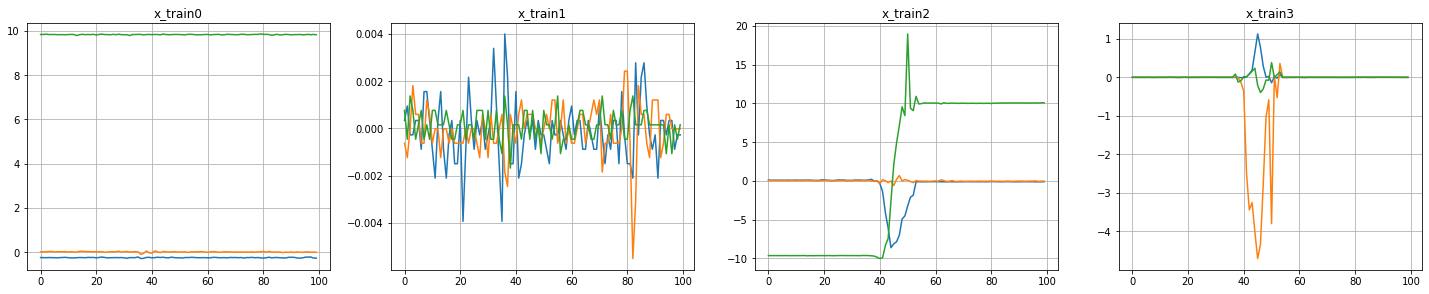

In [2]:
data_type = 'nonsvm'

if data_type == 'svm':
    data_set_path = './data_set/svm'
    save_path = f'./save_file/x_data_6_128_UCI_HAR_svm_acc/'
    x_data = np.load(data_set_path+"/x_data_6_128_UCI_HAR_svm_acc.npy")
    y_data = np.load(data_set_path+"/y_data_6_128_UCI_HAR_svm_acc.npy")
    data_chennal = 1
else:
#     data_set_path = './data_set/nonsvm'
#     save_path = f'./save_file/x_data_6_128_UCI_HAR_nonsvm_acc/'
#     x_data = np.load(data_set_path+"/x_data_6_128_UCI_HAR_nonsvm_acc.npy")
#     y_data = np.load(data_set_path+"/y_data_6_128_UCI_HAR_nonsvm_acc.npy")
#     data_chennal = 3

    data_set_path = './data_set/nonsvm'
    save_path = './save_file/data_3_100_my_svm_acc+gyro'
    x_data = np.load(data_set_path+"/x_data_3_100_my_nonsvm_acc+gyro.npy")
    y_data = np.load(data_set_path+"/y_data_3_100_my_nonsvm_acc+gyro.npy")
    data_chennal = 3


    
# data_set_path = './data_set/my_data/class_9'
# data_set_path = './data_set/svm'

# save_path = './save_file/data_3_100_my_svm'
# save_path = './save_file/data_3_100_my_svm_acc+gyro'

# save_path = f'./save_file/x_data_6_128_UCI_HAR_svm_acc/'


# x_data = np.load(data_set_path+"/x_data_3_100_my_svm_acc+gyro.npy")
# y_data = np.load(data_set_path+"/y_data_3_100_my_svm_acc+gyro.npy")

# x_data = np.load(data_set_path+"/x_data_6_500_hard_svm_acc+gyro.npy")
# y_data = np.load(data_set_path+"/y_data_6_500_hard_svm_acc+gyro.npy")

# x_data = np.load(data_set_path+"/x_data_6_128_UCI_HAR_svm_acc.npy")
# y_data = np.load(data_set_path+"/y_data_6_128_UCI_HAR_svm_acc.npy")


print(x_data.shape, y_data.shape)

data_classes = 3

# # Normalization
# for idx in range(len(x_data)):
#     min = np.min(x_data[idx])
#     max = np.max(x_data[idx])
#     x_data[idx] = (x_data[idx] - min) / (max - min)

# fig = plt.figure(figsize=(25,10))

# for id in range(4):
#     ax = fig.add_subplot(2,4,id+1)
#     ax.plot(x_data[id])
#     ax.grid(True)
#     ax.set_title(f"x_train{id}")

# # Standardize
# for idx in range(len(x_data)):
#     standard_deviation = np.std(x_data[idx])
#     mean = np.mean(x_data[idx])
#     x_data[idx] = (x_data[idx] - mean) / standard_deviation


# fig = plt.figure(figsize=(25,10))

# for id in range(4):
#     ax = fig.add_subplot(2,4,id+1)
#     ax.plot(x_data[id])
#     ax.grid(True)
#     ax.set_title(f"x_train{id}")

fig = plt.figure(figsize=(25,10))

for id in range(4):
    ax = fig.add_subplot(2,4,id+1)
    ax.plot(x_data[id])
    ax.grid(True)
    ax.set_title(f"x_train{id}")



## Data split


#data_set_구분
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1, shuffle=False)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#y_data onehot encoding
y_train = keras.utils.to_categorical(y_train, data_classes)
y_test = keras.utils.to_categorical(y_test, data_classes)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

## Data packaging

x_train = x_train.reshape(-1, 100,1)
x_test  = x_test.reshape(-1, 100,1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# k fold cross validation

In [3]:
#y_data onehot encoding
if data_type == 'svm':
    x = x_data.reshape(-1, 128,data_chennal)
else:
    x = x_data.reshape(-1, 100,data_chennal)
    
y = keras.utils.to_categorical(y_data)
print(x.shape, y.shape)


(2160, 100, 3) (2160, 3)


In [4]:

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec


# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall



# Model

# version 3

In [5]:
# %run ./models/DCNNNet_concate_plus.ipynb
# %run ./models/DCNNNet_concate_plus3.ipynb


# %run ./models/DCNNNet.ipynb

# createModel(depth=101, input_shape=(x.shape[1],1), extension_rate=4, classes=data_classes )

%run ./models/DCNNNet_best1-t1.ipynb

createModelNew(input_shape=(x.shape[1], data_chennal), extension_rate=24, classes=data_classes )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 100, 3)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100, 3)       0           input[0][0]                      
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 50, 3)        0           input[0][0]                      
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 50, 3)        0           input[0][0]                      
__________________________________________________________________________________________________
lambda_4 (

# traning

In [ ]:
if not os.path.isdir(save_path):
    os.makedirs(save_path)

batch_size = 64
split_val = 0.3
fit_shuffle = True
optimizer = 'sgd'
start_lr = 1e-2

split_shuffle = False
history = []
my_models = []

def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr
        

    

    
# 3. 모델 학습과정 설정하기
sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)


# adam = Adam(lr=lr_schedule(0))
# nAdam = Nadam(lr=lr_schedule(0))


# model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])



# modelv3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
#                                                                          f1_m, recall_m, precision_m])



from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import StratifiedShuffleSplit
# Instantiate the cross validator

skf = StratifiedKFold(n_splits=3, shuffle=True)
# Loop through the indices the split() method returns

for index, (train_indices, val_indices) in enumerate(skf.split(x_data, y_data)):

#     print(x[train_indices], x[val_indices])
#     print(y[train_indices], y[val_indices])
    xtrain, xval = x[train_indices], x[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]
    
    model = None
#     model = createModel(depth=101, input_shape=(x.shape[1],1), extension_rate=8, classes=data_classes )
    model = createModelNew(input_shape=(x.shape[1], data_chennal), extension_rate=12, classes=data_classes )
    

    
    r_reducer = ReduceLROnPlateau(monitor='val_loss',
                                  verbose=1,
                                  factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
    
#     csv_logger_path = save_path+f'/{index}.{model.name}_nonsvm,ex=24,cropping(k=6),[6,6,6,6],ReduceLROnPlateau_log.csv'
    csv_logger_path = save_path+f'/m2_test2/{index}.{model.name}_test_log.csv'

    if not os.path.isdir(os.path.dirname(csv_logger_path)):
        os.makedirs(os.path.dirname(csv_logger_path))
    csv_logger = CSVLogger(csv_logger_path, append=True)

    lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

    callbacks = [lr_scheduler, lr_scheduler, csv_logger]


    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
                                                              
                                                                single_class_precision(0), single_class_recall(0),
                                                                single_class_precision(1), single_class_recall(1),
                                                                single_class_precision(2), single_class_recall(2),
                                                                single_class_precision(3), single_class_recall(3),
                                                                single_class_precision(4), single_class_recall(4),
                                                                single_class_precision(5), single_class_recall(5),
#                                                                 single_class_precision(6), single_class_recall(6),
#                                                                 single_class_precision(7), single_class_recall(7),
#                                                                 single_class_precision(8), single_class_recall(8)
                                                                            f1_m, recall_m, precision_m
                                                                          ]) 
    
    
    history.append(model.fit(xtrain, ytrain, 
                        epochs=600, batch_size=batch_size, 
                        shuffle=fit_shuffle,
#                         workers=4, 
                        validation_data=(xval, yval),
                        callbacks=callbacks))

    my_models.append(model)

# # 4. 모델 학습시키기
# history = modelv3.fit(x_train, y_train, 
#                     epochs=300, batch_size=batch_size, 
#                     shuffle=fit_shuffle,
# #                     workers=1, 
#                       validation_data=(x_test, y_test),
#                     callbacks=callbacks)

# histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

# 6. 모델 평가하기
# evaluate = modelv3.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



epoch:  0
Learning rate:  0.01
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 100, 3)       0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 100, 3)       0           input[0][0]                      
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 50, 3)        0           input[0][0]                      
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, 50, 3)        0           input[0][0]                      
______________________________________________________________________________

Train on 1440 samples, validate on 720 samples
Epoch 1/600
epoch:  0
Learning rate:  0.01
epoch:  0
Learning rate:  0.01
1440/1440 [==============================] - 27s 19ms/step - loss: 0.4830 - acc: 0.8243 - prec: 0.8140 - recall: 0.8718 - prec_1: 0.7933 - recall_1: 0.7806 - prec_2: 0.8412 - recall_2: 0.8261 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 0.8137 - recall_m: 0.7854 - precision_m: 0.8519 - val_loss: 0.4890 - val_acc: 0.8208 - val_prec: 0.3442 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.2194 - val_prec_2: 0.3725 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.8208 - val_recall_m: 0.8208 - val_precision_m: 0.8208
Epoch 2/600
epoch:  1
Learning rate:  0.01
epoch:  1
Learning rate:  0.01
1440/1440 [=========================

Epoch 11/600
epoch:  10
Learning rate:  0.01
epoch:  10
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0129 - acc: 0.9958 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9899 - recall_1: 0.9979 - prec_2: 0.9980 - recall_2: 0.9905 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 0.9958 - recall_m: 0.9958 - precision_m: 0.9958 - val_loss: 0.0357 - val_acc: 0.9917 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4403 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9924 - val_recall_m: 0.9917 - val_precision_m: 0.9931
Epoch 12/600
epoch:  11
Learning rate:  0.01
epoch:  11
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0036 - acc: 

Epoch 21/600
epoch:  20
Learning rate:  0.01
epoch:  20
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0026 - acc: 0.9993 - prec: 0.9974 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9982 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 0.9993 - recall_m: 0.9993 - precision_m: 0.9993 - val_loss: 0.0301 - val_acc: 0.9931 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9931 - val_recall_m: 0.9931 - val_precision_m: 0.9931
Epoch 22/600
epoch:  21
Learning rate:  0.01
epoch:  21
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0013 - acc: 

Epoch 31/600
epoch:  30
Learning rate:  0.01
epoch:  30
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0021 - acc: 0.9993 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9977 - prec_2: 0.9972 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 0.9993 - recall_m: 0.9993 - precision_m: 0.9993 - val_loss: 0.0561 - val_acc: 0.9931 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9931 - val_recall_m: 0.9931 - val_precision_m: 0.9931
Epoch 32/600
epoch:  31
Learning rate:  0.01
epoch:  31
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0026 - acc: 

Epoch 41/600
epoch:  40
Learning rate:  0.01
epoch:  40
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9332e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0350 - val_acc: 0.9931 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9931 - val_recall_m: 0.9931 - val_precision_m: 0.9931
Epoch 42/600
epoch:  41
Learning rate:  0.01
epoch:  41
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0028 - a

Epoch 51/600
epoch:  50
Learning rate:  0.01
epoch:  50
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.7236e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0319 - val_acc: 0.9944 - val_prec: 0.3556 - val_recall: 0.3542 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9944 - val_recall_m: 0.9944 - val_precision_m: 0.9944
Epoch 52/600
epoch:  51
Learning rate:  0.01
epoch:  51
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.3700e-04

Epoch 61/600
epoch:  60
Learning rate:  0.01
epoch:  60
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.7808e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0304 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 62/600
epoch:  61
Learning rate:  0.01
epoch:  61
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 6.4827e-05

Epoch 71/600
epoch:  70
Learning rate:  0.01
epoch:  70
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 4.9627e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0331 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 72/600
epoch:  71
Learning rate:  0.01
epoch:  71
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 4.4633e-05

Epoch 81/600
epoch:  80
Learning rate:  0.01
epoch:  80
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.9818e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0331 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 82/600
epoch:  81
Learning rate:  0.01
epoch:  81
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.3250e-05

Epoch 91/600
epoch:  90
Learning rate:  0.01
epoch:  90
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 3.2552e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0310 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 92/600
epoch:  91
Learning rate:  0.01
epoch:  91
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 4.2653e-05

Epoch 101/600
epoch:  100
Learning rate:  0.01
epoch:  100
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 8.8872e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0320 - val_acc: 0.9931 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9931 - val_recall_m: 0.9931 - val_precision_m: 0.9931
Epoch 102/600
epoch:  101
Learning rate:  0.01
epoch:  101
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 6.10

Epoch 111/600
epoch:  110
Learning rate:  0.01
epoch:  110
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 7.5913e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0338 - val_acc: 0.9931 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9931 - val_recall_m: 0.9931 - val_precision_m: 0.9931
Epoch 112/600
epoch:  111
Learning rate:  0.01
epoch:  111
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 4.39

Epoch 121/600
epoch:  120
Learning rate:  0.01
epoch:  120
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 5.4428e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0333 - val_acc: 0.9931 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9931 - val_recall_m: 0.9931 - val_precision_m: 0.9931
Epoch 122/600
epoch:  121
Learning rate:  0.01
epoch:  121
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.13

Epoch 131/600
epoch:  130
Learning rate:  0.01
epoch:  130
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.6003e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0334 - val_acc: 0.9944 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4431 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9944 - val_recall_m: 0.9944 - val_precision_m: 0.9944
Epoch 132/600
epoch:  131
Learning rate:  0.01
epoch:  131
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 4.59

Epoch 141/600
epoch:  140
Learning rate:  0.01
epoch:  140
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9484e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0348 - val_acc: 0.9944 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4431 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9944 - val_recall_m: 0.9944 - val_precision_m: 0.9944
Epoch 142/600
epoch:  141
Learning rate:  0.01
epoch:  141
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 4.66

Epoch 151/600
epoch:  150
Learning rate:  0.01
epoch:  150
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 3.4791e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0340 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 152/600
epoch:  151
Learning rate:  0.001
epoch:  151
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.

Epoch 161/600
epoch:  160
Learning rate:  0.001
epoch:  160
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 5.4255e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0338 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 162/600
epoch:  161
Learning rate:  0.001
epoch:  161
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 171/600
epoch:  170
Learning rate:  0.001
epoch:  170
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.2378e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0339 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 172/600
epoch:  171
Learning rate:  0.001
epoch:  171
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 181/600
epoch:  180
Learning rate:  0.001
epoch:  180
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 3.6001e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0338 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 182/600
epoch:  181
Learning rate:  0.001
epoch:  181
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 191/600
epoch:  190
Learning rate:  0.001
epoch:  190
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.5797e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0340 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 192/600
epoch:  191
Learning rate:  0.001
epoch:  191
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 201/600
epoch:  200
Learning rate:  0.001
epoch:  200
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.8381e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0339 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 202/600
epoch:  201
Learning rate:  0.001
epoch:  201
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 211/600
epoch:  210
Learning rate:  0.001
epoch:  210
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.1407e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0334 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 212/600
epoch:  211
Learning rate:  0.001
epoch:  211
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 221/600
epoch:  220
Learning rate:  0.001
epoch:  220
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9286e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0327 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 222/600
epoch:  221
Learning rate:  0.001
epoch:  221
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 231/600
epoch:  230
Learning rate:  0.0001
epoch:  230
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.8434e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 232/600
epoch:  231
Learning rate:  0.0001
epoch:  231
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 241/600
epoch:  240
Learning rate:  0.0001
epoch:  240
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.4720e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 242/600
epoch:  241
Learning rate:  0.0001
epoch:  241
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 251/600
epoch:  250
Learning rate:  0.0001
epoch:  250
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9284e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0325 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 252/600
epoch:  251
Learning rate:  0.0001
epoch:  251
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 261/600
epoch:  260
Learning rate:  0.0001
epoch:  260
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 3.2108e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0325 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 262/600
epoch:  261
Learning rate:  0.0001
epoch:  261
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 271/600
epoch:  270
Learning rate:  0.0001
epoch:  270
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9846e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0325 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 272/600
epoch:  271
Learning rate:  0.0001
epoch:  271
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 281/600
epoch:  280
Learning rate:  0.0001
epoch:  280
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.6045e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0324 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 282/600
epoch:  281
Learning rate:  0.0001
epoch:  281
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 291/600
epoch:  290
Learning rate:  0.0001
epoch:  290
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.4537e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0327 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 292/600
epoch:  291
Learning rate:  0.0001
epoch:  291
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 301/600
epoch:  300
Learning rate:  0.0001
epoch:  300
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.5420e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0325 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 302/600
epoch:  301
Learning rate:  0.0001
epoch:  301
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 311/600
epoch:  310
Learning rate:  0.0001
epoch:  310
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 7.1723e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0325 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 312/600
epoch:  311
Learning rate:  0.0001
epoch:  311
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 321/600
epoch:  320
Learning rate:  0.0001
epoch:  320
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 4.2712e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 322/600
epoch:  321
Learning rate:  0.0001
epoch:  321
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 331/600
epoch:  330
Learning rate:  0.0001
epoch:  330
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.4719e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 332/600
epoch:  331
Learning rate:  0.0001
epoch:  331
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 341/600
epoch:  340
Learning rate:  0.0001
epoch:  340
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9046e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 342/600
epoch:  341
Learning rate:  0.0001
epoch:  341
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 351/600
epoch:  350
Learning rate:  0.0001
epoch:  350
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.2127e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 352/600
epoch:  351
Learning rate:  0.0001
epoch:  351
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 361/600
epoch:  360
Learning rate:  0.0001
epoch:  360
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.4849e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0325 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 362/600
epoch:  361
Learning rate:  0.0001
epoch:  361
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 371/600
epoch:  370
Learning rate:  0.0001
epoch:  370
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.8664e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 372/600
epoch:  371
Learning rate:  0.0001
epoch:  371
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 381/600
epoch:  380
Learning rate:  0.0001
epoch:  380
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.7812e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 382/600
epoch:  381
Learning rate:  0.0001
epoch:  381
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 391/600
epoch:  390
Learning rate:  0.0001
epoch:  390
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9237e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 392/600
epoch:  391
Learning rate:  0.0001
epoch:  391
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 401/600
epoch:  400
Learning rate:  0.0001
epoch:  400
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.6668e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0325 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 402/600
epoch:  401
Learning rate:  0.0001
epoch:  401
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 411/600
epoch:  410
Learning rate:  0.0001
epoch:  410
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.1921e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 412/600
epoch:  411
Learning rate:  0.0001
epoch:  411
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 421/600
epoch:  420
Learning rate:  0.0001
epoch:  420
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.5571e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0327 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 422/600
epoch:  421
Learning rate:  0.0001
epoch:  421
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 431/600
epoch:  430
Learning rate:  0.0001
epoch:  430
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.5746e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 432/600
epoch:  431
Learning rate:  0.0001
epoch:  431
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 441/600
epoch:  440
Learning rate:  0.0001
epoch:  440
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.3815e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 442/600
epoch:  441
Learning rate:  0.0001
epoch:  441
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 451/600
epoch:  450
Learning rate:  0.0001
epoch:  450
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.7809e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 452/600
epoch:  451
Learning rate:  0.0001
epoch:  451
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 461/600
epoch:  460
Learning rate:  0.0001
epoch:  460
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 3.0400e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0328 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 462/600
epoch:  461
Learning rate:  0.0001
epoch:  461
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 471/600
epoch:  470
Learning rate:  0.0001
epoch:  470
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.2166e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0325 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 472/600
epoch:  471
Learning rate:  0.0001
epoch:  471
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 481/600
epoch:  480
Learning rate:  0.0001
epoch:  480
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.4695e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 482/600
epoch:  481
Learning rate:  0.0001
epoch:  481
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 491/600
epoch:  490
Learning rate:  0.0001
epoch:  490
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.1185e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0327 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 492/600
epoch:  491
Learning rate:  0.0001
epoch:  491
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 501/600
epoch:  500
Learning rate:  0.0001
epoch:  500
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.1930e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 502/600
epoch:  501
Learning rate:  0.0001
epoch:  501
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 511/600
epoch:  510
Learning rate:  0.0001
epoch:  510
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.2426e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 512/600
epoch:  511
Learning rate:  0.0001
epoch:  511
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 521/600
epoch:  520
Learning rate:  0.0001
epoch:  520
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.4636e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0327 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 522/600
epoch:  521
Learning rate:  0.0001
epoch:  521
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 531/600
epoch:  530
Learning rate:  0.0001
epoch:  530
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.6554e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0327 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 532/600
epoch:  531
Learning rate:  0.0001
epoch:  531
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 541/600
epoch:  540
Learning rate:  0.0001
epoch:  540
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.3451e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 542/600
epoch:  541
Learning rate:  0.0001
epoch:  541
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 551/600
epoch:  550
Learning rate:  0.0001
epoch:  550
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 3.2118e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0325 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 552/600
epoch:  551
Learning rate:  0.0001
epoch:  551
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 561/600
epoch:  560
Learning rate:  0.0001
epoch:  560
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.7556e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 562/600
epoch:  561
Learning rate:  0.0001
epoch:  561
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 571/600
epoch:  570
Learning rate:  0.0001
epoch:  570
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.6053e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0327 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 572/600
epoch:  571
Learning rate:  0.0001
epoch:  571
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 581/600
epoch:  580
Learning rate:  0.0001
epoch:  580
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.6721e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0326 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 582/600
epoch:  581
Learning rate:  0.0001
epoch:  581
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 591/600
epoch:  590
Learning rate:  0.0001
epoch:  590
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.3259e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0327 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 592/600
epoch:  591
Learning rate:  0.0001
epoch:  591
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 100, 3)       0                                            
__________________________________________________________________________________________________
lambda_31 (Lambda)              (None, 100, 3)       0           input[0][0]                      
__________________________________________________________________________________________________
lambda_32 (Lambda)              (None, 50, 3)        0           input[0][0]                      
__________________________________________________________________________________________________
lambda_33 (Lambda)              (None, 50, 3)        0           input[0][0]                      
__________________________________________________________________________________________________
lambda_34 

Train on 1440 samples, validate on 720 samples
Epoch 1/600
epoch:  0
Learning rate:  0.01
epoch:  0
Learning rate:  0.01
1440/1440 [==============================] - 23s 16ms/step - loss: 0.4351 - acc: 0.8639 - prec: 0.9185 - recall: 0.9743 - prec_1: 0.8087 - recall_1: 0.8344 - prec_2: 0.8544 - recall_2: 0.7935 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 0.7971 - recall_m: 0.7333 - precision_m: 0.9084 - val_loss: 0.0905 - val_acc: 0.9944 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3722 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9944 - val_recall_m: 0.9944 - val_precision_m: 0.9944
Epoch 2/600
epoch:  1
Learning rate:  0.01
epoch:  1
Learning rate:  0.01
1440/1440 [=========================

Epoch 11/600
epoch:  10
Learning rate:  0.01
epoch:  10
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0134 - acc: 0.9965 - prec: 0.9975 - recall: 1.0000 - prec_1: 0.9917 - recall_1: 0.9969 - prec_2: 0.9960 - recall_2: 0.9946 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 0.9965 - recall_m: 0.9965 - precision_m: 0.9965 - val_loss: 0.0148 - val_acc: 0.9944 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4403 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9944 - val_recall_m: 0.9944 - val_precision_m: 0.9944
Epoch 12/600
epoch:  11
Learning rate:  0.01
epoch:  11
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0018 - acc: 

Epoch 21/600
epoch:  20
Learning rate:  0.01
epoch:  20
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 4.8655e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0152 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 22/600
epoch:  21
Learning rate:  0.01
epoch:  21
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 3.3933e-04

Epoch 31/600
epoch:  30
Learning rate:  0.01
epoch:  30
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.2441e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0161 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 32/600
epoch:  31
Learning rate:  0.01
epoch:  31
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.8522e-04

Epoch 41/600
epoch:  40
Learning rate:  0.01
epoch:  40
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9276e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0166 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 42/600
epoch:  41
Learning rate:  0.01
epoch:  41
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0057 - a

Epoch 51/600
epoch:  50
Learning rate:  0.01
epoch:  50
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.5366e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0216 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 52/600
epoch:  51
Learning rate:  0.01
epoch:  51
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 3.9085e-04

Epoch 61/600
epoch:  60
Learning rate:  0.01
epoch:  60
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.7337e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0195 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 62/600
epoch:  61
Learning rate:  0.01
epoch:  61
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.3875e-04

Epoch 71/600
epoch:  70
Learning rate:  0.01
epoch:  70
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.7035e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0177 - val_acc: 0.9972 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9972 - val_recall_m: 0.9972 - val_precision_m: 0.9972
Epoch 72/600
epoch:  71
Learning rate:  0.01
epoch:  71
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.2279e-04

Epoch 81/600
epoch:  80
Learning rate:  0.01
epoch:  80
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9025e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0196 - val_acc: 0.9972 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4444 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9972 - val_recall_m: 0.9972 - val_precision_m: 0.9972
Epoch 82/600
epoch:  81
Learning rate:  0.01
epoch:  81
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 9.5335e-05

Epoch 91/600
epoch:  90
Learning rate:  0.01
epoch:  90
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 7.5582e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0216 - val_acc: 0.9944 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9944 - val_recall_m: 0.9944 - val_precision_m: 0.9944
Epoch 92/600
epoch:  91
Learning rate:  0.01
epoch:  91
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 5.1768e-04

Epoch 101/600
epoch:  100
Learning rate:  0.01
epoch:  100
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 0.0013 - acc: 0.9993 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9977 - prec_2: 0.9978 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 0.9993 - recall_m: 0.9993 - precision_m: 0.9993 - val_loss: 0.0196 - val_acc: 0.9944 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3736 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9944 - val_recall_m: 0.9944 - val_precision_m: 0.9944
Epoch 102/600
epoch:  101
Learning rate:  0.01
epoch:  101
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.0422e-

Epoch 111/600
epoch:  110
Learning rate:  0.01
epoch:  110
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.5821e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0175 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 112/600
epoch:  111
Learning rate:  0.01
epoch:  111
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.09

Epoch 121/600
epoch:  120
Learning rate:  0.01
epoch:  120
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.9142e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0185 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 122/600
epoch:  121
Learning rate:  0.01
epoch:  121
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.74

Epoch 131/600
epoch:  130
Learning rate:  0.01
epoch:  130
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.6075e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0225 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 132/600
epoch:  131
Learning rate:  0.01
epoch:  131
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 2.00

Epoch 141/600
epoch:  140
Learning rate:  0.01
epoch:  140
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 3.5661e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0206 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 142/600
epoch:  141
Learning rate:  0.01
epoch:  141
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 1.50

Epoch 151/600
epoch:  150
Learning rate:  0.01
epoch:  150
Learning rate:  0.01
1440/1440 [==============================] - 3s 2ms/step - loss: 6.6052e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0191 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 152/600
epoch:  151
Learning rate:  0.001
epoch:  151
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 9.

Epoch 161/600
epoch:  160
Learning rate:  0.001
epoch:  160
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 8.2785e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0197 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 162/600
epoch:  161
Learning rate:  0.001
epoch:  161
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 171/600
epoch:  170
Learning rate:  0.001
epoch:  170
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 8.1193e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0196 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 172/600
epoch:  171
Learning rate:  0.001
epoch:  171
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 181/600
epoch:  180
Learning rate:  0.001
epoch:  180
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 2.8247e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0198 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 182/600
epoch:  181
Learning rate:  0.001
epoch:  181
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 191/600
epoch:  190
Learning rate:  0.001
epoch:  190
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 4.2991e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 192/600
epoch:  191
Learning rate:  0.001
epoch:  191
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 201/600
epoch:  200
Learning rate:  0.001
epoch:  200
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 5.9059e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0202 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 202/600
epoch:  201
Learning rate:  0.001
epoch:  201
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 211/600
epoch:  210
Learning rate:  0.001
epoch:  210
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 7.1589e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 212/600
epoch:  211
Learning rate:  0.001
epoch:  211
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 221/600
epoch:  220
Learning rate:  0.001
epoch:  220
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 4.3272e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 222/600
epoch:  221
Learning rate:  0.001
epoch:  221
Learning rate:  0.001
1440/1440 [==============================] - 3s 2ms/step - loss: 

Epoch 231/600
epoch:  230
Learning rate:  0.0001
epoch:  230
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 3.9194e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0199 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 232/600
epoch:  231
Learning rate:  0.0001
epoch:  231
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 241/600
epoch:  240
Learning rate:  0.0001
epoch:  240
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 4.2481e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0199 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 242/600
epoch:  241
Learning rate:  0.0001
epoch:  241
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 251/600
epoch:  250
Learning rate:  0.0001
epoch:  250
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.2572e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 252/600
epoch:  251
Learning rate:  0.0001
epoch:  251
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 261/600
epoch:  260
Learning rate:  0.0001
epoch:  260
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 7.0048e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 262/600
epoch:  261
Learning rate:  0.0001
epoch:  261
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 271/600
epoch:  270
Learning rate:  0.0001
epoch:  270
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 6.9711e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 272/600
epoch:  271
Learning rate:  0.0001
epoch:  271
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 281/600
epoch:  280
Learning rate:  0.0001
epoch:  280
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 4.8014e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 282/600
epoch:  281
Learning rate:  0.0001
epoch:  281
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 291/600
epoch:  290
Learning rate:  0.0001
epoch:  290
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 6.4885e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0199 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 292/600
epoch:  291
Learning rate:  0.0001
epoch:  291
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 301/600
epoch:  300
Learning rate:  0.0001
epoch:  300
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 1.1703e-04 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 302/600
epoch:  301
Learning rate:  0.0001
epoch:  301
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 311/600
epoch:  310
Learning rate:  0.0001
epoch:  310
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 6.0091e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0199 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 312/600
epoch:  311
Learning rate:  0.0001
epoch:  311
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 321/600
epoch:  320
Learning rate:  0.0001
epoch:  320
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 5.0564e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0199 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 322/600
epoch:  321
Learning rate:  0.0001
epoch:  321
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 331/600
epoch:  330
Learning rate:  0.0001
epoch:  330
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 4.8803e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 332/600
epoch:  331
Learning rate:  0.0001
epoch:  331
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 341/600
epoch:  340
Learning rate:  0.0001
epoch:  340
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 6.8454e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 342/600
epoch:  341
Learning rate:  0.0001
epoch:  341
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 351/600
epoch:  350
Learning rate:  0.0001
epoch:  350
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 8.6122e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 352/600
epoch:  351
Learning rate:  0.0001
epoch:  351
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 361/600
epoch:  360
Learning rate:  0.0001
epoch:  360
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 8.3865e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0200 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 362/600
epoch:  361
Learning rate:  0.0001
epoch:  361
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

Epoch 371/600
epoch:  370
Learning rate:  0.0001
epoch:  370
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - loss: 6.4415e-05 - acc: 1.0000 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.0000e+00 - recall_3: 0.0000e+00 - prec_4: 0.0000e+00 - recall_4: 0.0000e+00 - prec_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_m: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0202 - val_acc: 0.9958 - val_prec: 0.3556 - val_recall: 0.3556 - val_prec_1: 0.4444 - val_recall_1: 0.4417 - val_prec_2: 0.3778 - val_recall_2: 0.3750 - val_prec_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_prec_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_prec_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_m: 0.9958 - val_recall_m: 0.9958 - val_precision_m: 0.9958
Epoch 372/600
epoch:  371
Learning rate:  0.0001
epoch:  371
Learning rate:  0.0001
1440/1440 [==============================] - 3s 2ms/step - lo

In [ ]:

evaluate = modelv3.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("loss     acc      f1      recall      precision")
print(evaluate)


In [ ]:
for hist in history:
    for key, value in hist.history.items():
        if key == "val_acc":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_f1_m":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall_m":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_precision_m":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_prec":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_prec_1":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall_1":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_prec_2":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall_2":
            value = max(value)
            print(key, value)